# Cohort 7.3 Mass Spec Blood Analysis

### Imports and environment setup

- Date of run: 2025-06-20
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import all functions from ../code/cohort_analysis_utils.py
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')   

# Remove cell printing limits
pd.set_option('display.max_rows', None)

# Data loading and preprosessing

## PG matrix

We're working with the PG (protein) matrix of the MS experiment, and considering the 116 samples.

In [4]:
df = pd.read_csv('../data/ms/cohort_7_3_MS_pg.csv', index_col='Protein.Names', header=0, sep='\t')

In [5]:
# Name harmonization
df.columns = list(df.columns[0:3]) + \
             [ c.replace('/users/pr/rawstream/2025NK011/mzml/', '')[0:len("2025NK011_EVCO_001")] for c in df.columns[3:] ]

In [6]:
# Convert to numeric 
df.iloc[:, 3:] = df.iloc[:, 3:].replace(0, np.nan)
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')

In [7]:
# Remove the first 3 columns, keeping only the protein names as columns
df = df.iloc[:, 3:]

In [8]:
# Keep a log2 transformation of the data
df = np.log2(df)

In [9]:
# Transpose, columns are now proteins and rows are samples, as in ELISA
df = df.T

In [10]:
######## NORMALIZATION TO THE MEDIAN ########
#df = df.subtract(df.median(axis=1), axis=0)

In [11]:
# The biomarkers are now the columns of the dataframe
BIOMARKERS = list(df.columns)

### Metadata

In [12]:
df_metadata = pd.read_csv('../data/cohort_7.3_metadata.csv', index_col='id_ms', header=0, sep='\t')

In [13]:
df['Pathology'] = df_metadata['Pathology']
df['Endometrial_thickness'] = df_metadata['Endometrial_thickness']


In [14]:
df = df.dropna(subset=['Pathology'])

In [15]:
df = df.T

Plasma markers considered in this study are albumin, HBA and HBB hemoglobins, fibrinogen alpha, alpha-1-acid glycoprotein, haptoglobin, transferrin, apolipoproteins and complements C3, C4A and C4B.

In [16]:
plasma_markers = [
    'ALBU_HUMAN',  # Albumin
    #'HBA_HUMAN', 'HBB_HUMAN',  # Hemoglobins
    #'FIBA_HUMAN',  # Fibrinogen alpha
    #'A1AG1_HUMAN', 'A1AG2_HUMAN',  # alpha-1-acid glycoprotein
    #'HPT_HUMAN', # Haptoglobin
    'TRFE_HUMAN', # Transferrin
    #'APOA1_HUMAN', 'APOB_HUMAN', 'APOC3_HUMAN',  # Apolipoproteins
    #'C3_HUMAN', 'C4A_HUMAN', 'C4B_HUMAN'  # Complement
]

all_blood_markers = [
    'ALBU_HUMAN',  # Albumin
    'HBA_HUMAN', 'HBB_HUMAN',  # Hemoglobins
    'FIBA_HUMAN',  # Fibrinogen alpha
    'A1AG1_HUMAN', 'A1AG2_HUMAN',  # alpha-1-acid glycoprotein
    'HPT_HUMAN', # Haptoglobin
    'TRFE_HUMAN', # Transferrin
    'APOA1_HUMAN', 'APOB_HUMAN', 'APOC3_HUMAN',  # Apolipoproteins
    'CO3_HUMAN', 'CO4A_HUMAN', 'CO4B_HUMAN'  # Complement
]

The blood index for each sample is calculated as the sum of intensities of selected plasma markers divided by the sum of intensities of all biomarkers, giving a normalized measure of plasma marker abundance per sample.

In [17]:
valid_markers = [p for p in plasma_markers if p in df.index]

df_linear = np.power(2, df.T[BIOMARKERS])

df_zscores = df_linear[BIOMARKERS].apply(lambda x: (x) / x.std(), axis=0)


In [18]:
blood_index = df_zscores[valid_markers].sum(axis=1) / df_zscores[BIOMARKERS].sum(axis=1)

blood_index_df = blood_index.rename("BloodIndex")

In [19]:
df_blood_index = df.copy().T
df_blood_index['BloodIndex'] = blood_index_df


In [20]:
# df_blood_index Pathology=="Benign" should be 0, Pathology=="EC" should be 1
df_blood_index.Pathology = df_blood_index.Pathology.map({'Benign': 0, 'EC': 1})

A statistical test is performed in order to see if there is significant differences in the blood index of the benign and the cancer samples.

In [21]:
from scipy.stats import mannwhitneyu

# Remove NaN values from BloodIndex
df_blood_index = df_blood_index.dropna(subset=['BloodIndex'])
# Make it numeric
df_blood_index['BloodIndex'] = pd.to_numeric(df_blood_index['BloodIndex'], errors='coerce')

g0 = df_blood_index[df_blood_index.Pathology == 0]["BloodIndex"]
g1 = df_blood_index[df_blood_index.Pathology == 1]["BloodIndex"]

u, p = mannwhitneyu(g0, g1, alternative='two-sided')
print(f"Mann-Whitney U test: U={u:.2f}, p={p:.3g}")
# Interpretation of p-value
if p < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

Mann-Whitney U test: U=2056.00, p=0.0389
There is a significant difference between the two groups.


<Axes: xlabel='Pathology', ylabel='BloodIndex'>

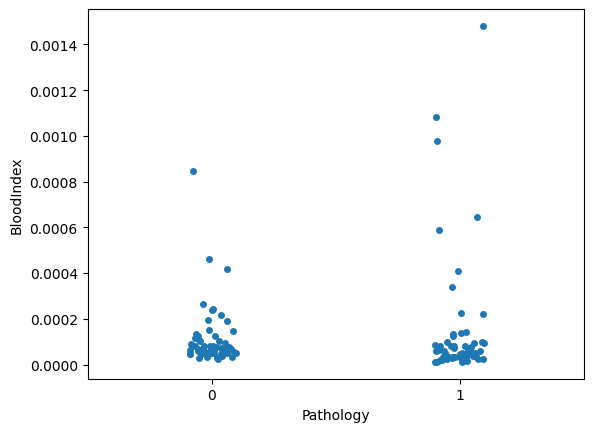

In [22]:
sns.stripplot(data=df_blood_index, x="Pathology", y="BloodIndex", jitter=True)


### Blood Index Correction (per-protein)

To assess and correct for the impact of blood contamination on protein intensities, we computed a **Blood Index** per sample. This index was defined as the total intensity of a curated set of plasma proteins (e.g., ALB, HBB, FGA, APOA1) divided by the total protein intensity.

To determine whether Blood Index is associated with pathology (benign vs cancer), we performed a Mann–Whitney U test, resulting in a p-value of 0.0389, suggesting a statistically significant difference in blood content between groups.

However, the distribution of Blood Index across samples shows considerable within-group variability and overlap. This supports the use of Blood Index as a covariate in subsequent protein-level modeling.

We therefore implemented a per-protein linear correction modeling the intensity of each protein as a function of Blood Index. Specifically, for each protein *i* and sample *j*, we fit:

$$
\log_2(I_{ij}) = \beta_{0i} + \gamma_i \cdot \text{BloodIndex}_j + \epsilon_{ij}
$$

The coefficient $\gamma_i$ captures the degree to which protein *i* abundance varies with blood content. We estimated $\gamma_i$ using only benign samples to avoid removing true biological signal from tumor biology.

The adjusted abundance is then computed as:

$$
I^{\text{corrected}}_{ij} = I_{ij} - \gamma_i \cdot \text{BloodIndex}_j
$$

This per-protein correction reduces the confounding effect of variable blood contamination while preserving true disease-related expression changes. These corrected values are then used for biomarker performance analyses.


In [23]:
from sklearn.linear_model import LinearRegression

# Copy the original dataframe
df_corrected = df_blood_index.copy()

# Get the list of protein columns
non_protein_cols = ['Protein.Names', 'Pathology', 'Endometrial_thickness', 'BloodIndex']
protein_cols = [col for col in df_blood_index.columns if col not in non_protein_cols]

# Loop over all proteins
for prot in protein_cols:
    y = df_blood_index[prot]
    x = df_blood_index['BloodIndex']
    pathology = df_blood_index['Pathology']
    
    # Use only benign samples to estimate gamma_i
    benign_mask = (pathology == 0) & (~y.isna()) & (~x.isna())
    if benign_mask.sum() < 3:  # skip proteins with too few values
        continue

    X_benign = x[benign_mask].values.reshape(-1, 1)
    y_benign = y[benign_mask].values

    model = LinearRegression()
    model.fit(X_benign, y_benign)
    gamma_i = model.coef_[0]

    # Apply correction to all samples
    correction = gamma_i * x
    df_corrected[prot] = y - correction

As an example, let's observe how the values of MMP9 are corrected on each sample based on the blood index.

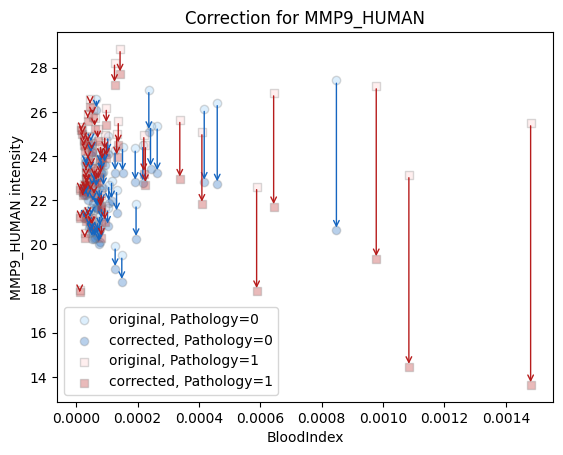

In [24]:
prot = 'MMP9_HUMAN'  # Example protein to visualize
markers = {0: 'o', 1: 's'}  # 0: circle, 1: square

# Define consistent colors: light for original, dark for corrected
colors = {
    0: {'orig': '#90caf9', 'corr': '#1565c0'},  # blue shades for benign
    1: {'orig': '#ffcccb', 'corr': '#b71c1c'}   # red shades for EC
}

for pathology, marker in markers.items():
    mask = df_blood_index['Pathology'] == pathology
    x_orig = df_blood_index.loc[mask, 'BloodIndex']
    y_orig = df_blood_index.loc[mask, prot]
    y_corr = df_corrected.loc[mask, prot]

    plt.scatter(
        x_orig, y_orig,
        label=f'original, Pathology={pathology}',
        marker=marker,
        alpha=0.3,
        color=colors[pathology]['orig'],
        edgecolor='grey'
    )
    plt.scatter(
        x_orig, y_corr,
        label=f'corrected, Pathology={pathology}',
        marker=marker,
        alpha=0.3,
        color=colors[pathology]['corr'],
        edgecolor='grey'
    )

    # Draw arrows from original to corrected
    for x, y0, y1 in zip(x_orig, y_orig, y_corr):
        plt.annotate(
            '',
            xy=(x, y1),
            xytext=(x, y0),
            arrowprops=dict(arrowstyle='->', color=colors[pathology]['corr'], lw=1)
        )

plt.xlabel('BloodIndex')
plt.ylabel(f'{prot} intensity')
plt.legend()
plt.title(f'Correction for {prot}')
plt.show()

In [25]:
crg_discarded_samples = ['2025NK011_EVCO_003',
 '2025NK011_EVCO_023',
 '2025NK011_EVCO_031',
 '2025NK011_EVCO_040',
 '2025NK011_EVCO_046',
 '2025NK011_EVCO_049',
 '2025NK011_EVCO_062',
 '2025NK011_EVCO_065',
 '2025NK011_EVCO_072',
 '2025NK011_EVCO_088',
 '2025NK011_EVCO_110']

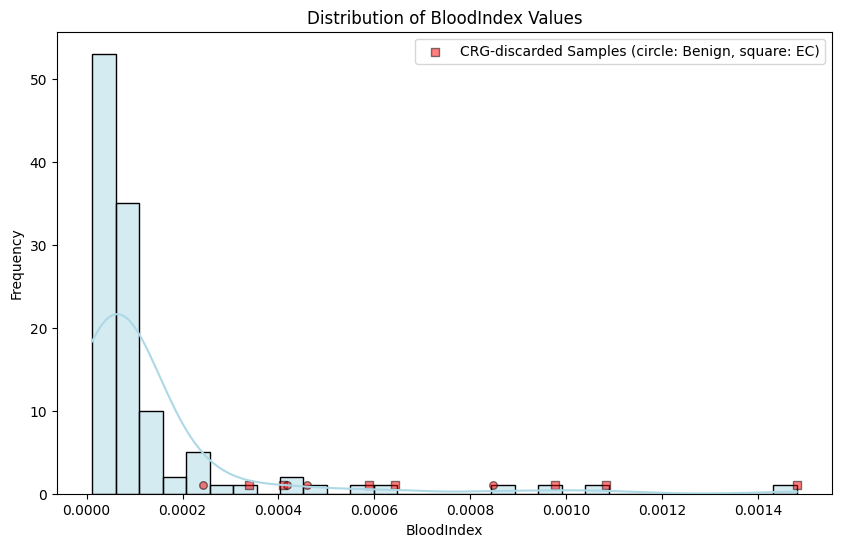

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(df_blood_index['BloodIndex'], bins=30, kde=True, color='lightblue', edgecolor='black')

# Get the blood index and pathology for the discarded samples
discarded_samples = df_blood_index.loc[crg_discarded_samples, 'BloodIndex']
discarded_pathologies = df_blood_index.loc[crg_discarded_samples, 'Pathology']

# Define marker mapping
marker_map = {0: 'o', 1: 's'}

# Plot each discarded sample with its corresponding marker
for idx, (x, pathology) in enumerate(zip(discarded_samples, discarded_pathologies)):
    plt.scatter(
        x, 1, 
        color='red',
        s=30,
        marker=marker_map.get(pathology, 'o'),
        label='CRG-discarded Samples (circle: Benign, square: EC)' if idx == 0 else "",
        edgecolor='black',
        alpha=0.5
    )

plt.title('Distribution of BloodIndex Values')
plt.xlabel('BloodIndex')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [34]:
discarded_samples

2025NK011_EVCO_003    0.001481
2025NK011_EVCO_023    0.000588
2025NK011_EVCO_031    0.000643
2025NK011_EVCO_040    0.000460
2025NK011_EVCO_046    0.001084
2025NK011_EVCO_049    0.000848
2025NK011_EVCO_062    0.000410
2025NK011_EVCO_065    0.000978
2025NK011_EVCO_072    0.000417
2025NK011_EVCO_088    0.000338
2025NK011_EVCO_110    0.000242
Name: BloodIndex, dtype: float64

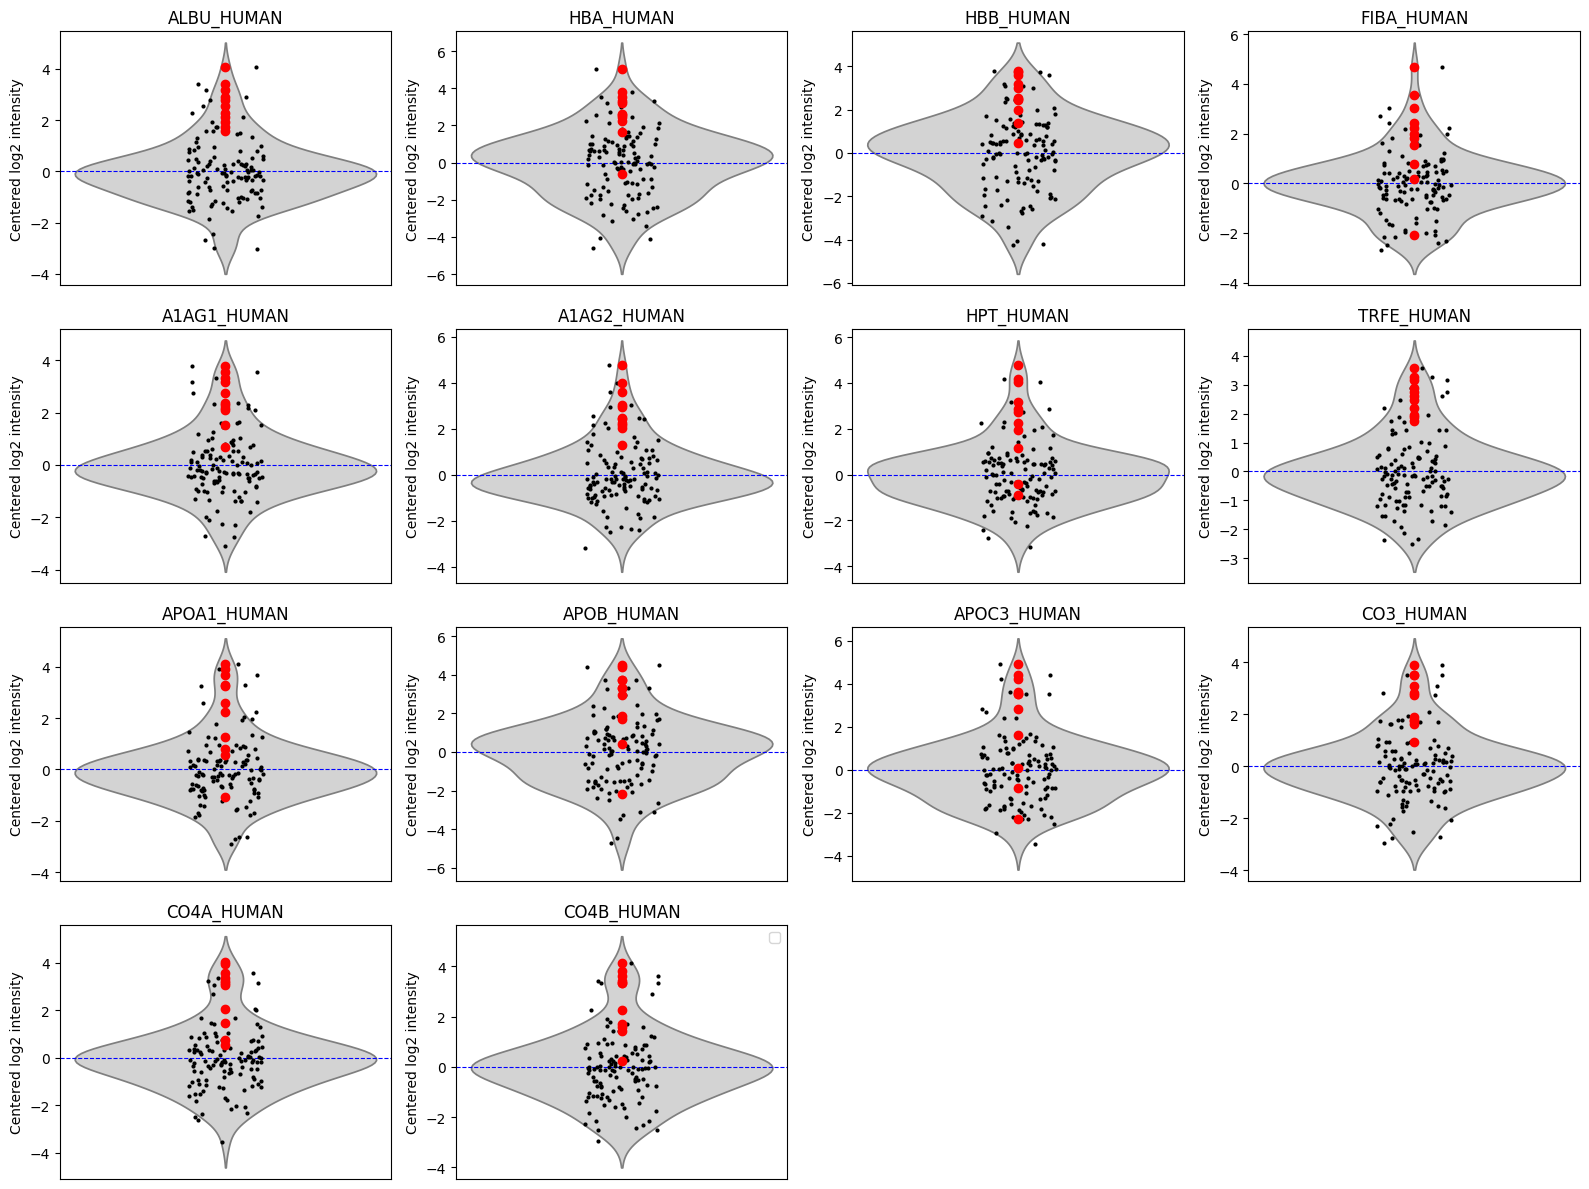

In [28]:
# Step 1: extract protein matrix (samples as rows, proteins as columns)
X = df_blood_index[BIOMARKERS]

# Step 2: subtract per-sample mean  row-wise centering
df_log_centered = X.sub(X.mean(axis=0), axis=1)

# Step 3: plot violin + highlight discarded samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

n = len(all_blood_markers)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows))
axes = axes.flatten()

for i, marker in enumerate(all_blood_markers):
    ax = axes[i]

    sns.violinplot(y=df_log_centered[marker], ax=ax, inner=None, color="lightgrey")
    sns.stripplot(y=df_log_centered[marker], ax=ax, color="black", size=3)

    # Discarded sample values
    discarded_vals = df_log_centered.loc[df_log_centered.index.isin(crg_discarded_samples), marker]
    ax.scatter(
        np.full_like(discarded_vals, 0),  # x-position fixed at center
        discarded_vals,
        color="red",
        label="discarded" if i == 0 else None,
        zorder=3
    )

    ax.axhline(0, color="blue", linestyle="--", linewidth=0.8)
    ax.set_title(marker)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("Centered log2 intensity")

# Clean up unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.legend()
plt.show()


### AUCs calculations

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve

df = df_corrected.copy()

auc_scores = {}
sensitivity_max_sum = {}
specificity_max_sum = {}
sensitivity_high = {}
specificity_for_high_sens = {}
threshold_max_sum = {}
threshold_high_sens = {}
log2FC = {}
n_pos = {}
n_neg = {}

# Only keep biomarkers that have reads in at least 90% of the samples
min_samples = 0.9 * df.shape[0]
BIOMARKERS = [biomarker for biomarker in BIOMARKERS if df[biomarker].count() >= min_samples]

df_not_discarded = df[~df.index.isin(crg_discarded_samples)]

for biomarker in BIOMARKERS:
    if df_not_discarded[biomarker].isnull().any():
        # Ignore Nans in the biomarker column and get the corresponding Pathology values
        y_true = df_not_discarded.Pathology[df_not_discarded[biomarker].notnull()]
        y_score = df_not_discarded[biomarker][df_not_discarded[biomarker].notnull()]
        #print(f"Processing biomarker: {biomarker} with NaNs removed")
    else:
        y_true = df_not_discarded.Pathology
        y_score = df_not_discarded[biomarker]
    
    if len(y_true) == 0 or len(y_score) == 0:
        continue 
        
    auc = roc_auc_score(y_true, y_score)
    
    # Check if AUC < 0.5, invert if needed
    invert = False
    if auc < 0.5:
        invert = True
        auc = 1 - auc
        y_score = -y_score  # Invert the prediction scores
    
    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # Specificity = 1 - fpr
    specificity = 1 - fpr
    
    # Criterion 1: Find threshold that maximizes (sensitivity + specificity)
    sum_sens_spec = tpr + specificity
    optimal_idx = np.argmax(sum_sens_spec)
    
    # Criterion 2: Find threshold with max specificity where sensitivity > 0.95
    high_sens_indices = np.where(tpr >= 0.95)[0]
    if len(high_sens_indices) > 0:
        high_sens_optimal_idx = high_sens_indices[np.argmax(specificity[high_sens_indices])]
        sens_high = tpr[high_sens_optimal_idx]
        spec_high = specificity[high_sens_optimal_idx]
        thresh_high = thresholds[high_sens_optimal_idx] if high_sens_optimal_idx < len(thresholds) else np.nan
    else:
        sens_high = np.nan
        spec_high = np.nan
        thresh_high = np.nan
        
    auc_scores[biomarker] = round(float(auc), 3)
    sensitivity_max_sum[biomarker] = round(float(tpr[optimal_idx]), 3)
    specificity_max_sum[biomarker] = round(float(specificity[optimal_idx]), 3)
    sensitivity_high[biomarker] = round(float(sens_high), 3)
    specificity_for_high_sens[biomarker] = round(float(spec_high), 3)
    threshold_max_sum[biomarker] = round(float(thresholds[optimal_idx] if optimal_idx < len(thresholds) else np.nan), 3)
    threshold_high_sens[biomarker] = round(float(thresh_high), 3)
    log2FC[biomarker] = round(float(df_not_discarded[biomarker].groupby(df_not_discarded['Pathology']).mean().diff().iloc[-1]), 3)
    n_pos[biomarker] = df_not_discarded[df_not_discarded.Pathology == 1][biomarker].count()
    n_neg[biomarker] = df_not_discarded[df_not_discarded.Pathology == 0][biomarker].count()
    
# Sort by AUC
auc_scores = dict(sorted(auc_scores.items(), key=lambda item: item[1], reverse=True))

# Create dataframe with all metrics
result_df = pd.DataFrame({
    'Biomarker': list(auc_scores.keys()),
    'AUC': list(auc_scores.values()),
    'Sensitivity (max sum)': [sensitivity_max_sum[biomarker] for biomarker in auc_scores.keys()],
    'Specificity (max sum)': [specificity_max_sum[biomarker] for biomarker in auc_scores.keys()],
    #'Threshold (max sum)': [threshold_max_sum[biomarker] for biomarker in auc_scores.keys()],
    'Sensitivity (sens > 95%)': [sensitivity_high[biomarker] for biomarker in auc_scores.keys()],
    'Specificity (sens > 95%)': [specificity_for_high_sens[biomarker] for biomarker in auc_scores.keys()],
    #'Threshold (high sens)': [threshold_high_sens[biomarker] for biomarker in auc_scores.keys()],
    'Log2FC': [log2FC[biomarker] for biomarker in auc_scores.keys()],
    #'p-value': [pvalues[biomarker] for biomarker in auc_scores.keys()],
    #'Adjusted p-value': [adjusted_pvalues[biomarker] for biomarker in auc_scores.keys()],
    'n_pos': [n_pos[biomarker] for biomarker in auc_scores.keys()],
    'n_neg': [n_neg[biomarker] for biomarker in auc_scores.keys()]
})

#### Over MMK biomarkers

In [36]:
# Set mimark biomarkers to check if results are consistent with the CRG data
MMK_BIOMARKERS = ["AGRIN_HUMAN", "MMP9_HUMAN", "TIMP2_HUMAN", 
                    "KPYM_HUMAN", "PERM_HUMAN", "MVP_HUMAN", "NGAL_HUMAN", "CLIC1_HUMAN", 
                    "PIGR_HUMAN"]

In [37]:
result_df_mmk = result_df[result_df['Biomarker'].isin(MMK_BIOMARKERS)]
result_df_mmk = result_df_mmk.sort_values(by='AUC', ascending=False)
result_df_mmk

,Biomarker,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg
390,KPYM_HUMAN,0.882,0.769,0.868,0.962,0.623,0.659,52,53
1301,AGRIN_HUMAN,0.748,0.538,0.868,0.962,0.170,0.919,52,53
1331,CLIC1_HUMAN,0.744,0.788,0.679,0.962,0.226,0.326,52,53
1525,TIMP2_HUMAN,0.722,0.827,0.509,0.962,0.208,-0.930,52,53
1794,MMP9_HUMAN,0.696,0.788,0.547,0.962,0.151,1.202,52,53
1925,PIGR_HUMAN,0.684,0.808,0.472,0.962,0.170,-1.376,52,53
2014,PERM_HUMAN,0.674,0.712,0.642,0.981,0.151,1.194,52,53
2620,NGAL_HUMAN,0.620,0.692,0.566,1.000,0.000,-0.763,52,53
2637,MVP_HUMAN,0.619,0.346,0.906,0.962,0.019,0.408,52,53


Let's compare it with the 105-samples original AUCs:


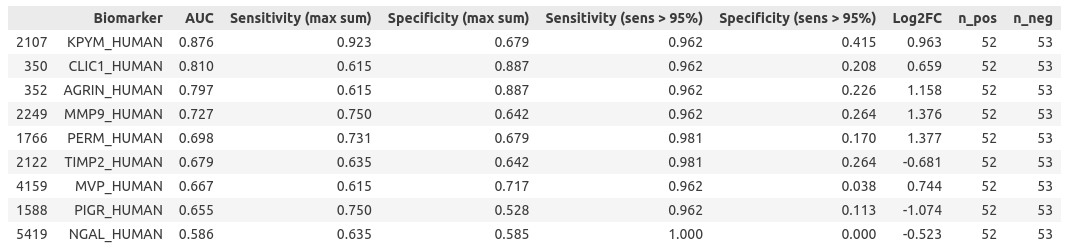

#### Over ALL biomarkers

In [38]:
result_df.sort_values(by='AUC', ascending=False).head(10)

,Biomarker,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg
0,CYBP_HUMAN,0.993,0.981,0.981,0.962,1.000,1.204,52,53
1,CLIC2_HUMAN,0.986,0.962,0.943,0.962,0.943,-2.164,52,53
2,VINEX_HUMAN,0.986,0.961,0.962,0.961,0.962,-1.903,51,53
3,IDI1_HUMAN,0.986,0.923,0.981,0.962,0.904,1.601,52,52
4,ASNS_HUMAN,0.984,0.961,0.940,0.961,0.940,1.649,51,50
5,AGO1_HUMAN,0.982,0.904,0.981,0.981,0.887,-1.165,52,53
6,FHL1_HUMAN,0.981,0.941,0.962,0.961,0.925,-2.813,51,53
9,MYLK_HUMAN,0.980,0.962,0.943,0.962,0.943,-2.033,52,53
8,ACACA_HUMAN,0.980,0.922,0.980,0.961,0.820,0.979,51,50
7,FAS_HUMAN,0.980,0.942,0.962,0.962,0.849,1.463,52,53


Let's compare it with the 105-samples original AUCs:

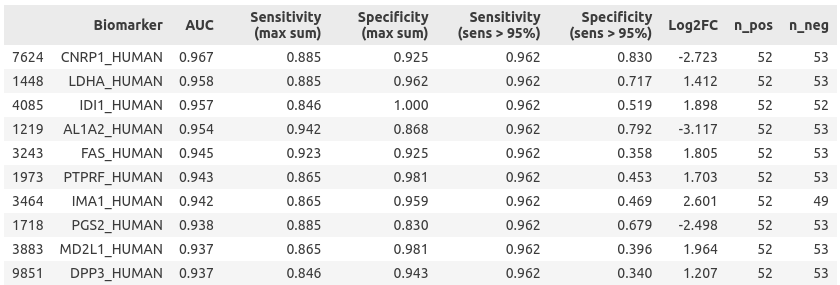